In [6]:
import numpy as np
import pandas as pd
import random
from scipy import stats
import matplotlib.pyplot as plt

## Data generation from Gaussian mixtures

In [7]:
# Define mean values for Gaussian distributions
mu_1 = np.array([0, 0])
mu_2 = np.array([3, 0])
mu_3 = np.array([0, 3])
means = list([mu_1, mu_2, mu_3])
print(means)

[array([0, 0]), array([3, 0]), array([0, 3])]


In [8]:
# Define covariances for Gaussian distributions 
cov_1 = np.array([[1, 0], [0, 1]])
cov_2 = np.array([[1, 0], [0, 1]])
cov_3 = np.array([[1, 0], [0, 1]])
covariances = list([cov_1, cov_2, cov_3])
print(covariances)

[array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]])]


In [9]:
# Define the parameter for discrete distribution
pi = [0.2, 0.5, 0.3]

In [10]:
def GMM_sampling(pi, means, covariances):
  """ 
  Data points sampling using Gaussian mixtures
    Input:  
            pi : the discrete distribution parameter
        labels : vector of labels, sampled from the discrete distribution
        means : list of mean vectors for the Gaussians
        covariances: list of covariance matrices for the Gaussian
    Output:
        x_data : data sample 
  """
  # Define discrete distribution 
  k = np.arange(len(pi))
  discrete_dist = stats.rv_discrete(name='discrete_dist', values=(k, pi))
  labels = discrete_dist.rvs(size=500)
  labels = sorted(labels)
  # Generate gaussian samples 
  unique, counts = np.unique(labels, return_counts=True)
  x_values = []
  label_dict = dict(zip(unique, counts))
  for value, counts in label_dict.items():
    value_cluster = np.random.multivariate_normal(means[value].T, covariances[value], counts)
    x_values.append(value_cluster)
  
  x_data = np.vstack(x_values)

  return x_data, labels


In [11]:
x_data, labels = GMM_sampling(pi, means, covariances)

In [12]:
data_dict = {'x1': x_data[:, 0], 'x2': x_data[:, 1], 'true label': labels}

In [13]:
df_true = pd.DataFrame(data_dict)

In [14]:
# Shuffle the rows of data frame
df_true = df_true.sample(frac = 1).reset_index(drop=True)

In [15]:
df_true.head()

,x1,x2,true label
0,2.905972,1.148247,1
1,-0.211966,0.661467,0
2,2.131893,0.776710,1
3,3.428423,1.032410,1
4,3.801391,0.538713,1


In [16]:
df_true['true label'].value_counts()

1    244
2    155
0    101
Name: true label, dtype: int64

In [17]:
X_data = df_true[['x1','x2']].values
y_data = df_true[['true label']].values

In [ ]:
y_data = np.concatenate(y_data).ravel()

In [ ]:
print(X_data.shape)
print(y_data.shape)

(500, 2)
(500,)


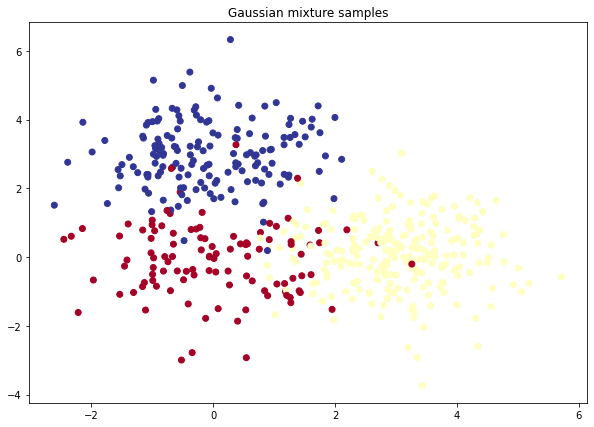

In [ ]:
# Plot scatted data from three Gaussian distributions 
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap=plt.cm.RdYlBu)
plt.title("Gaussian mixture samples")
plt.show()

## K-means clustering algorithm 

In [ ]:
def cluster_update(X_data, centroids, K):
  """ 
  Assignment of clusters for fixed centroid vectors
    Input:  
        X_data : the covariates matrix (n=num of observations,d=num of features)
        centroids : the centroid matrix (K=number of clusters, d=num of features)
        K : the number of clusters 
    Output:
        c_сluster: the cluster assignment list
  """
  c_cluster = []
  for x_point in X_data:
    x_cent = x_point - centroids
    x_cent_norms = np.sum(x_cent**2, axis = 1)
    x_cent_norms = x_cent_norms.reshape((K, 1))
    cluster=np.where(x_cent_norms == np.amin(x_cent_norms))[0]
    cluster=cluster.astype(int)
    c_cluster.append(cluster[0])          
  return c_cluster

In [ ]:
def centroids_update(X_data, c_cluster, K):
  """ 
    The computation of centroid vectors for assigned clusters
    Input:
        X_data : the covariates matrix (n=num of observations,d=num of features)
        с_cluster : the cluster assignment list 
        K : the number of clusters 
    Output:
        centroids : the centroid matrix (K=number of clusters, d=num of features)
  """  
  centroids = np.zeros((K, X_data.shape[1]))       
  for k in range(K):
    ii  = list(filter(lambda x: c_cluster[x] == k, range(len(c_cluster))))
    X_cluster = X_data[ii,:]
    centroid = X_cluster.sum(axis=0, dtype='float')/X_cluster.shape[0]
    centroids[k,:] = centroid
  return centroids


In [ ]:
def compute_cost(X_data, c_cluster, centroids, K):
  """
    Compute a value of the cost function
    Input:
         X_data: the covariates matrix (n=num of observations,d=num of features)
         с_cluster: the cluster assignment list 
         centroids: the centroid matrix (K=number of clusters, d=num of features)
         K : the number of clusters 
    Output:
         cost_value: a value of the cost function
  """
  cost_value=0
  for k in range(K):
    ii = list(filter(lambda x: c_cluster[x] == k, range(len(c_cluster))))
    X_cluster = X_data[ii,:]
    centroid = centroids[k,:]
    cluster_norms = np.sum(np.abs(X_cluster-centroid)**2, axis=-1)
    cost_value+=np.sum(cluster_norms)
  return cost_value

In [ ]:
def K_means_clustering(X_data, K, N_iter):
  """
    K-means clustering algorithm 
    Input:
         X_data: the covariates matrix (n=num of observations,d=num of features)
         K : the number of clusters 
         N_iter : the number of iteration 
    Output:
         centroids: the centroid matrix (K=number of clusters, d=num of features)
         cost_hist : the cost value for each iteration
  """
  # Initialization of centroids 
  idx = np.random.randint(X_data.shape[0], size=K)
  centroids = X_data[idx, :]
  cost_hist=[]
  index_global = 0
  while index_global < N_iter:
    c_cluster = cluster_update(X_data, centroids, K)
    centroids = centroids_update(X_data, c_cluster, K)
    cost_value = compute_cost(X_data, c_cluster, centroids, K)
    cost_hist.append(cost_value)
    index_global+=1
  return c_cluster, centroids, cost_hist

In [ ]:
# Initialization of K-means:
N_iter = 20

[[ 3.30348797 -0.65117454]
 [ 1.16408896  3.4806935 ]
 [-1.15519845  0.78630831]]


In [ ]:
c_cluster3, centroids3, cost_hist3 = K_means_clustering(X_data, 3, N_iter)
c_cluster5, centroids5, cost_hist5 = K_means_clustering(X_data, 5, N_iter)
c_cluster7, centroids7, cost_hist7 = K_means_clustering(X_data, 7, N_iter)

In [ ]:
data_clustered = {'x1': X_data[:, 0], 'x2': X_data[:, 1], 'cluster values': c_cluster3}
df = pd.DataFrame(data_clustered)

In [ ]:
df.head()

,x1,x2,cluster values
0,2.903847,0.784653,0
1,2.849749,1.348454,0
2,-2.327924,0.605824,1
3,3.438775,-3.736137,0
4,2.703156,-0.659563,0


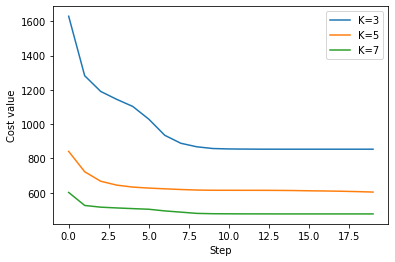

In [ ]:
# Plot convergence history 
steps = list(range(len(cost_hist3)))
plt.plot(steps, cost_hist3, label="K=3")
plt.plot(steps,cost_hist5, label='K=5')
plt.plot(steps,cost_hist7, label='K=7')
plt.xlabel('Step')
plt.ylabel("Cost value")
plt.legend()
plt.show()


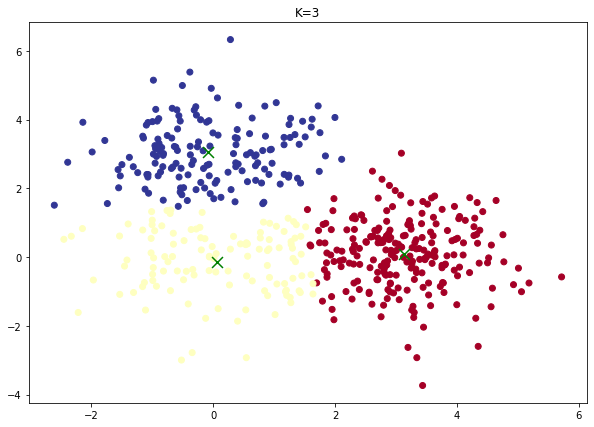

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(X_data[:, 0], X_data[:, 1], c=c_cluster3, cmap=plt.cm.RdYlBu)
ax.scatter(centroids3[:, 0], centroids3[:, 1], marker = 'x', s=120, c = 'g')
plt.title("K=3")
fig.show()

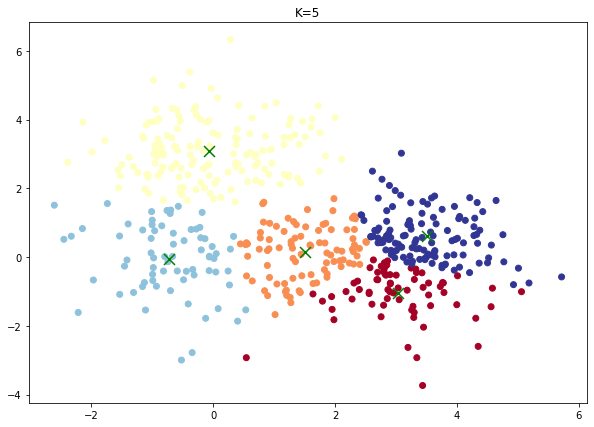

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(X_data[:, 0], X_data[:, 1], c=c_cluster5, cmap=plt.cm.RdYlBu)
ax.scatter(centroids5[:, 0], centroids5[:, 1], marker = 'x', s=120, c = 'g')
plt.title("K=5")
fig.show()

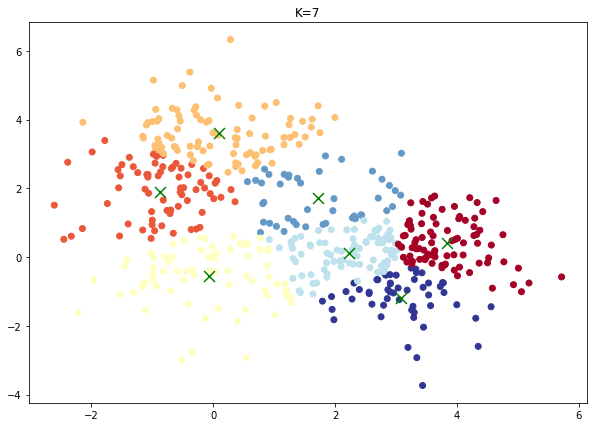

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(X_data[:, 0], X_data[:, 1], c=c_cluster7, cmap=plt.cm.RdYlBu)
ax.scatter(centroids7[:, 0], centroids7[:, 1], marker = 'x', s=120, c = 'g')
plt.title("K=7")
fig.show()

## Gaussian mixture clustering

In [58]:
def E_step(X_data, Pi, covariance_list, mu, K):
    """ E-step of EM algorithm

    Input:  
       X_data: the covariates matrix (n=num of observations,d=num of features)
       Pi: K-dimensional probability distribution, Pi[k, 1]=Pi_k
       covariance_list: list of covariance matrices for Gaussians; 
                        covariance_list[k]=covariance of k-th Gaussian
       mu: the means for Gaussians; mu[k,:]=mean vector (centroid) of k-th Gaussian
       K : the number of clusters 
    Output:
       Phi: probability matrix (n=number of points, K=number of clusters) 
            Phi[i,j] is the probability that i-th data point belongs to j-th cluster
    """
       
    n=X_data.shape[0]
    Phi=np.zeros((n,K))       
    index=0 
    for row in X_data:
        for k in range(K):
            Pi_k = Pi[k,:]
            mean_k = mu[k,:]
            cov_k = covariance_list[k]
            sigma_k_inv = np.linalg.inv(cov_k)
            rmk = row-mean_k
            rmk=rmk.reshape((1,X_data.shape[1]))
            exponent_input = -1/2*(np.dot(np.dot(rmk, sigma_k_inv), rmk.T))
            constant = Pi_k*(1/np.sqrt(abs(np.linalg.det(cov_k))))
            Phi[index,k] = constant*np.exp(exponent_input)
        index+=1
                    
    Phi_sum=Phi.sum(axis=1)   
    Phi=Phi/Phi_sum[:,np.newaxis]   
    return Phi


In [59]:
def M_step(X_data, Phi, K):
    """ M-step of EM algorithm: upgrades K-dimensional discrete distribution and Gaussians

   Input:  
       X_data : the covariates matrix (n=num of observations,d=num of features)
       Phi: probability matrix (n=number of points, K=number of clusters) 
       K : number of clusters 
  Output:
       Pi:  K-dimensional probability distribution, Pi[k,:]=Pi_k
       covariance_list: List of covariances for Gaussians; covariance_list[k]=covariance of k-th Gaussian
       mu:  means for Gaussians; mu[k,:]=mean vector (centroid) of k-th Gaussian
    """

    n=X_data.shape[0]
    d=X_data.shape[1]
    N_k=np.sum(Phi, axis=0) 
    N_k=N_k.reshape((1, K))     
    Pi=np.zeros((K,1))
    mu=np.zeros((K,d))
    covariance_list=[]
    for k in range(K):  
        Pi_k=N_k[:,k]/n
        Pi[k,:]=Pi_k
        Phi_k=Phi[:,k]
        Phi_diag = np.diag(Phi_k)
        mean_k=1/N_k[:,k]*np.sum(np.dot(Phi_diag, X_data), axis=0)
        mu[k,:]=mean_k
        row_means_k=X_data-mean_k
        cov_k=np.zeros((d,d))
        for i in range(n):
            row_means_i=row_means_k[i,:]
            cov_k+=Phi_k[i]*np.multiply.outer(row_means_i,row_means_i)    
        cov_k=1/N_k[:,k]*cov_k
        covariance_list.append(cov_k)
  
    return Pi, covariance_list, mu

In [60]:
def GMM_cost(Phi, Pi, K):
  """ Cost value computation for GMM
   Input:  
       Phi : probability matrix (n=number of points, K=number of clusters) 
       Pi : K-dimensional probability distribution, Pi[k,:]=Pi_k
       K : the number of clusters 
  Output:
   cost_value: the value of cost function for GMM algorithm
  """
  cost_value = 0
  n = Phi.shape[0]
  for i in range(n):
    sum_prob = 0
    for k in range(K):
      sum_prob+=Pi[k,:]*Phi[i,k]
  cost_value+=np.log(sum_prob)
  return cost_value


In [69]:
K=3
N_iter=30

def GMM_clustering(X_data, K, N_iter):
  """
    Gaussian mixture model clustering algorithm 
    Input:
         X_data: the covariates matrix (n=num of observations,d=num of features)
         K : the number of clusters 
         N_iter : the number of iteration 
    Output:
         Phi: probability matrix (n=number of points, K=number of clusters) 
         cost_GMM : the cost value for each iteration
  """

  d=X_data.shape[1] 

  # K-dim distributiion initialization
  Pi=1/K*np.ones((K,1))

  # Centroids initialization
  idx = np.random.randint(X_data.shape[0], size=K)
  mu = X_data[idx, :]
  # covariance initialization
  covariance_list=[]
  for k in range(K):
    cov_k=np.identity(d)
    covariance_list.append(cov_k)

  index_global=0
  cost_GMM = []
  while index_global<N_iter:
    Phi=E_step(X_data, Pi, covariance_list, mu, K)
    Pi, covariance_list, mu = M_step(X_data, Phi, K)
    cost = GMM_cost(Phi, Pi, K)
    cost_GMM.append(cost)
    index_global+=1
  return Phi, cost_GMM, mu, covariance_list

In [82]:
Phi, cost_GMM, mu, covariance_list = GMM_clustering(X_data, K, N_iter)

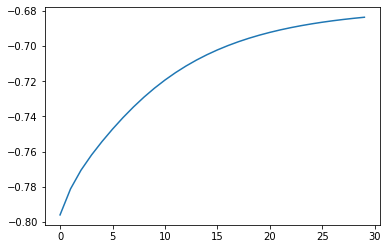

In [83]:
plt.plot(cost_GMM)

In [84]:
GMM_clusters = np.argmax(Phi, axis=1)

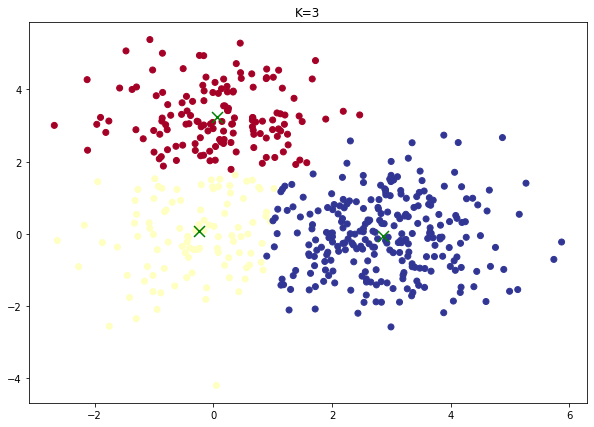

In [85]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(X_data[:, 0], X_data[:, 1], c=GMM_clusters, cmap=plt.cm.RdYlBu)
ax.scatter(mu[:, 0], mu[:, 1], marker = 'x', s=120, c = 'g')
plt.title("K=3")
fig.show()

In [86]:
# Show probabilities of first 10 points
print(Phi[:10, :])

[[1.20004786e-03 1.95549432e-03 9.96844458e-01]
 [2.63644847e-02 9.51484301e-01 2.21512146e-02]
 [3.04166411e-03 2.39427829e-02 9.73015553e-01]
 [1.53150742e-04 2.37070209e-04 9.99609779e-01]
 [7.46472410e-06 3.36133229e-05 9.99958922e-01]
 [1.97286703e-06 1.33877132e-05 9.99984639e-01]
 [1.33107385e-05 8.76083696e-01 1.23902993e-01]
 [2.84461625e-06 9.61554579e-01 3.84425765e-02]
 [8.34623840e-06 2.87947971e-03 9.97112174e-01]
 [9.86870721e-01 1.31022179e-02 2.70611196e-05]]
